In [3]:
# beta diversity of food
from scipy.spatial.distance import pdist, squareform
import pandas as pd


# Load the CSV file again
df = pd.read_csv('transformed_dataset_combined.csv')


# Remove the ID column and replace NaN values with 0
food_data = df.drop(columns=['ID']).fillna(0)


# Compute the Bray-Curtis beta diversity matrix
beta_div_matrix = pd.DataFrame(squareform(pdist(food_data.values, metric='braycurtis')), 
                               index=df["ID"], columns=df["ID"])

print(beta_div_matrix.head)


<bound method NDFrame.head of ID          x10MCx1134  x10MCx1146  x10MCx1150  x10MCx1162  x10MCx1171  \
ID                                                                       
x10MCx1134    0.000000    0.985826    1.000000    0.734131    1.000000   
x10MCx1146    0.985826    0.000000    1.000000    0.979663    0.990448   
x10MCx1150    1.000000    1.000000    0.000000    1.000000    1.000000   
x10MCx1162    0.734131    0.979663    1.000000    0.000000    0.877597   
x10MCx1171    1.000000    0.990448    1.000000    0.877597    0.000000   
...                ...         ...         ...         ...         ...   
x30MCx3382    0.661308    0.981260    0.988398    0.853672    0.884937   
x30MCx3394    1.000000    0.986834    0.995178    0.968507    0.968706   
x30MCx3412    1.000000    0.982408    0.985342    0.874203    0.831254   
x30MCx3422    0.940545    0.964728    0.990542    0.908926    0.946908   
x30MCx3423    1.000000    0.983871    0.987227    0.940245    0.793652   

ID     

In [40]:
# Load the transformed dataset
diet_data = pd.read_csv('transformed_dataset_combined.csv')

# fill NaN values with 0
diet_data = diet_data.fillna(0)
# save the diet data
diet_data.to_csv('transformed_dataset_combined.csv', index=False)



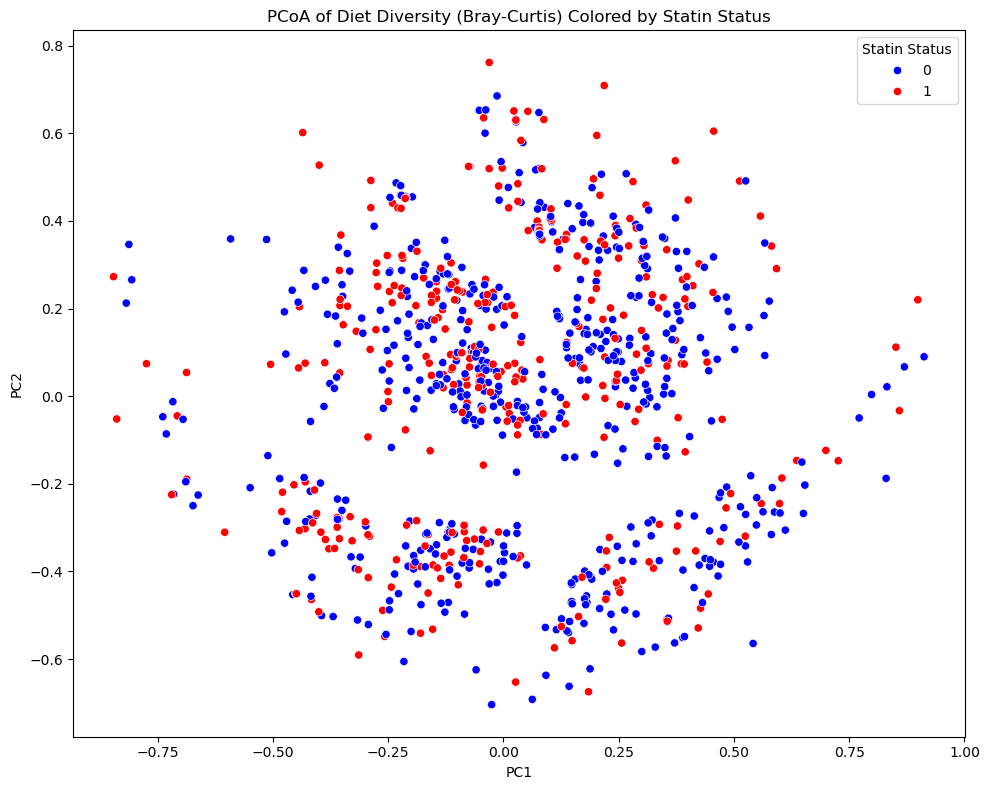


Summary Statistics by Statin Status:

Statin Status: 0
Number of individuals: 541
Average PC1: 0.0555
Average PC2: -0.0114

Statin Status: 1
Number of individuals: 346
Average PC1: 0.0039
Average PC2: 0.0409

ANOVA test for PC1 by Statin Status:
F-statistic: 6.4148
p-value: 0.0115

Note: For a full PERMANOVA analysis, consider using the 'skbio' package or R's 'vegan' package

Diet Diversity Analysis:

Top 5 Most Diverse Diets:
              ID  Diet_Diversity
1376    x30MCx12        0.537968
1195  x20MCx2761        0.537565
1548  x30MCx1966        0.537376
1750  x30MCx2869        0.537317
627    x13MCx134        0.537307

Top 5 Least Diverse Diets:
              ID  Diet_Diversity
1011  x20MCx1999        0.003360
576   x12MCx2347        0.005331
1875  x30MCx3355        0.009331
397   x10MCx3246        0.013991
256   x10MCx2472        0.014202

Analysis complete. Results saved to CSV files and plots.


In [ ]:
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import numpy as np

# Load the transformed dataset
diet_data = pd.read_csv('foods.csv')

# Fill NaN values with 0
diet_data = diet_data.fillna(0)

# Set the ID column as the index
diet_data = diet_data.set_index('ID')

# Calculate Bray-Curtis dissimilarity matrix
numeric_diet_data = diet_data.apply(pd.to_numeric, errors='coerce').fillna(0)
bray_curtis_matrix = pairwise_distances(numeric_diet_data, metric='braycurtis')

# Create a DataFrame for the distance matrix
bc_df = pd.DataFrame(bray_curtis_matrix, 
                     index=diet_data.index, 
                     columns=diet_data.index)

# Perform PCoA (using MDS with a precomputed distance matrix)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_results = mds.fit_transform(bray_curtis_matrix)

# Create a DataFrame for PCoA results
pcoa_df = pd.DataFrame(pcoa_results, 
                       columns=['PC1', 'PC2'], 
                       index=diet_data.index)

# Load biomarkers data
biomarkers = pd.read_csv('biomarkers_cov.csv')

# If biomarkers data exists, merge with PCoA results
if not biomarkers.empty:
    # Reset index to prepare for merge
    pcoa_df = pcoa_df.reset_index()
    
    # Merge PCoA results with biomarkers data
    merged_data = pd.merge(pcoa_df, biomarkers, on='ID', how='inner')
    
    # Ensure that the original food_subgroup_* columns are preserved
    # Add the food_subgroup_* columns from diet_data to merged_data
    diet_data_reset = diet_data.reset_index()  # Reset index to merge on 'ID'
    merged_data = pd.merge(merged_data, diet_data_reset, on='ID', how='left')
    
    # Plot PCoA with statin status coloring
    plt.figure(figsize=(10, 8))
    
    # Check if 'Statin' column exists
    if 'Statin' in merged_data.columns:
        # Create scatter plot colored by statin status
        sns.scatterplot(x='PC1', y='PC2', 
                        hue='Statin', 
                        palette={0: 'blue', 1: 'red'},
                        data=merged_data)
        
        plt.title('PCoA of Diet Diversity (Bray-Curtis) Colored by Statin Status')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Statin Status')
    else:
        # Continue without statin status
        sns.scatterplot(x='PC1', y='PC2', data=pcoa_df)
        plt.title('PCoA of Diet Diversity (Bray-Curtis)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    plt.tight_layout()
    plt.savefig('diet_diversity_pcoa.png', dpi=300)
    plt.show()
    
    # Print some statistics about the clustering
    if 'Statin' in merged_data.columns:
        statin_groups = merged_data.groupby('Statin')
        print("\nSummary Statistics by Statin Status:")
        for name, group in statin_groups:
            print(f"\nStatin Status: {name}")
            print(f"Number of individuals: {len(group)}")
            print(f"Average PC1: {group['PC1'].mean():.4f}")
            print(f"Average PC2: {group['PC2'].mean():.4f}")
            
        # Calculate ANOVA to test if the groups are significantly different
        try:
            f_stat, p_val = f_oneway(
                merged_data[merged_data['Statin'] == 0]['PC1'],
                merged_data[merged_data['Statin'] == 1]['PC1']
            )
            print(f"\nANOVA test for PC1 by Statin Status:")
            print(f"F-statistic: {f_stat:.4f}")
            print(f"p-value: {p_val:.4f}")
            
            # For a proper PERMANOVA, you would need additional libraries like skbio or vegan in R
            print("\nNote: For a full PERMANOVA analysis, consider using the 'skbio' package or R's 'vegan' package")
        except Exception as e:
            print(f"Error performing statistical tests: {e}")
else:
    # Plot just the PCoA without statin status
    plt.figure(figsize=(10, 8))
    pcoa_df = pcoa_df.reset_index()
    sns.scatterplot(x='PC1', y='PC2', data=pcoa_df)
    plt.title('PCoA of Diet Diversity (Bray-Curtis)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.savefig('diet_diversity_pcoa_no_status.png', dpi=300)
    plt.show()

# Additional analysis: Calculate and print the most diverse diets
print("\nDiet Diversity Analysis:")
row_diversity = 1 - np.mean(bray_curtis_matrix, axis=1)
diversity_df = pd.DataFrame({
    'ID': diet_data.index,
    'Diet_Diversity': row_diversity
})

print("\nTop 5 Most Diverse Diets:")
print(diversity_df.sort_values('Diet_Diversity', ascending=False).head(5))

print("\nTop 5 Least Diverse Diets:")
print(diversity_df.sort_values('Diet_Diversity', ascending=True).head(5))

# Save results to CSV files
pcoa_df.to_csv('diet_pcoa_results.csv', index=False)
bc_df.to_csv('bray_curtis_matrix.csv', index=True)
diversity_df.to_csv('diet_diversity_scores.csv', index=False)

# Save merged data if it exists
if 'merged_data' in locals():
    merged_data.to_csv('foods_merged.csv', index=False)

print("\nAnalysis complete. Results saved to CSV files and plots.")

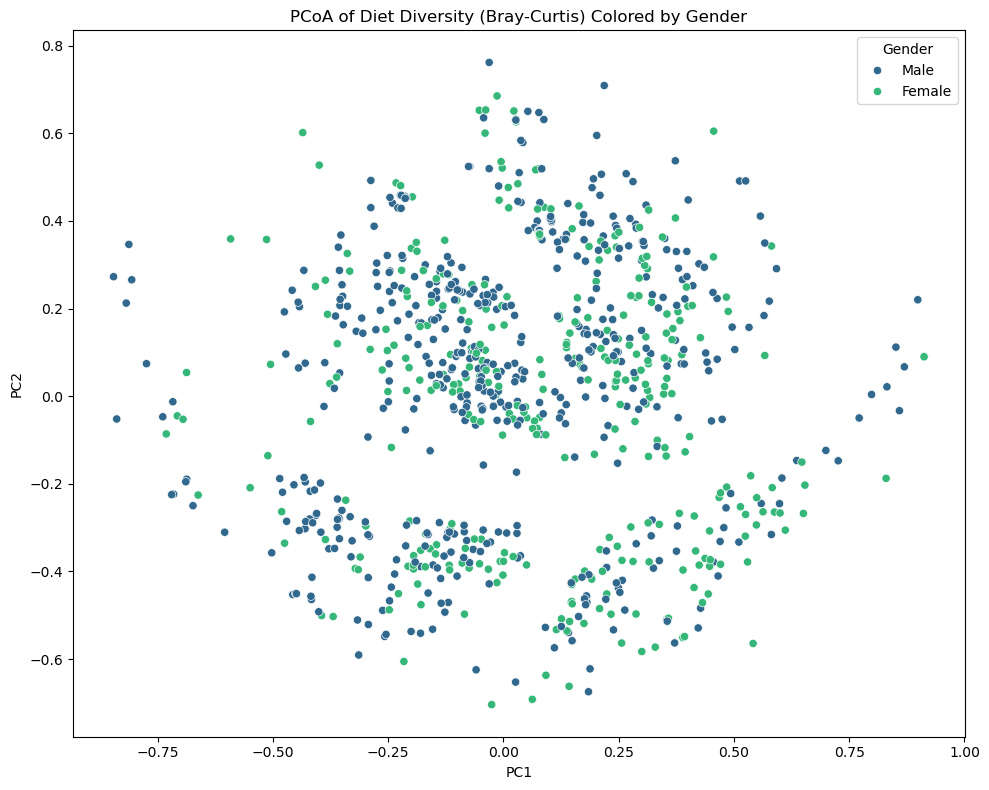

In [59]:
# Plot PCoA with gender coloring
plt.figure(figsize=(10, 8))

# Check if 'Gender' column exists
if 'Gender' in merged_data.columns:
    # Create scatter plot colored by gender
    sns.scatterplot(x='PC1', y='PC2', 
                   hue='Gender', 
                   palette='viridis',  # You can change the palette if needed
                   data=merged_data)
    
    plt.title('PCoA of Diet Diversity (Bray-Curtis) Colored by Gender')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Gender')
else:
    # If 'Gender' column doesn't exist, try to find an alternative status column
    gender_cols = [col for col in merged_data.columns if 'gender' in col.lower()]
    if gender_cols:
        print(f"'Gender' column not found. Using {gender_cols[0]} instead.")
        sns.scatterplot(x='PC1', y='PC2', 
                       hue=gender_cols[0], 
                       palette='viridis',
                       data=merged_data)
        plt.title(f'PCoA of Diet Diversity (Bray-Curtis) Colored by {gender_cols[0]}')
    else:
        # Default plot without coloring
        sns.scatterplot(x='PC1', y='PC2', data=merged_data)
        plt.title('PCoA of Diet Diversity (Bray-Curtis)')

plt.tight_layout()
plt.savefig('diet_diversity_pcoa.png', dpi=300)
plt.show()

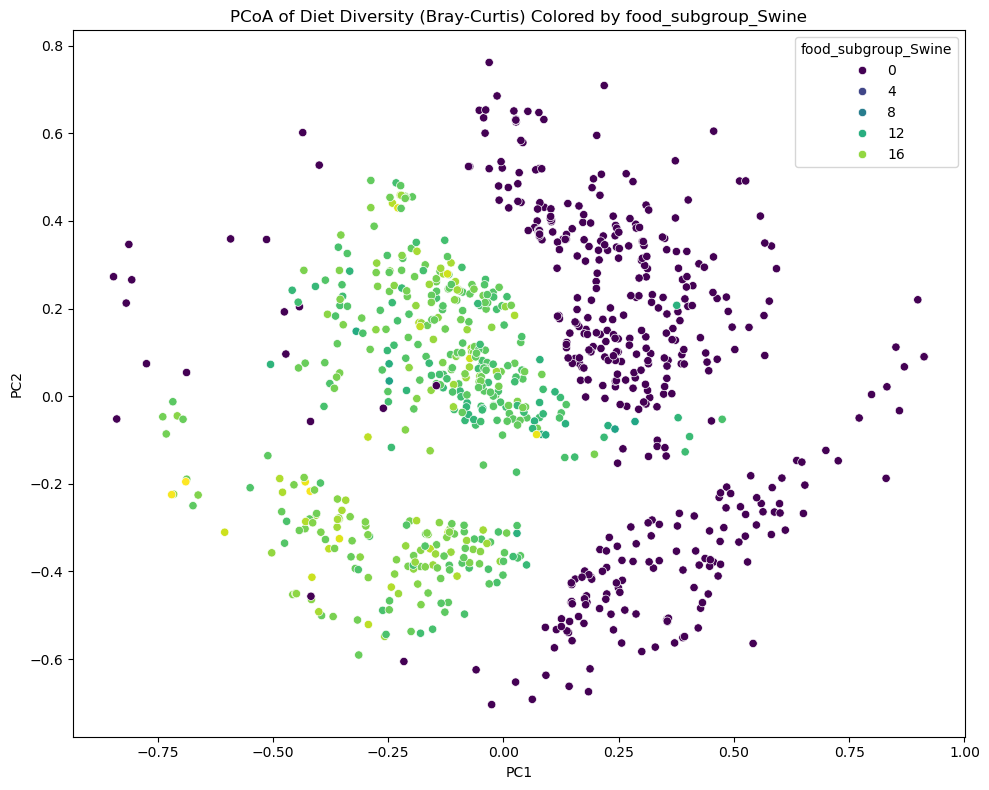

In [56]:
# Plot PCoA with coloring based on a column from diet_data
plt.figure(figsize=(10, 8))

# Select a column from diet_data to use for coloring
# For example, let's assume you want to use the column 'Fruit' from diet_data
color_column = 'food_subgroup_Swine'  #

# Merge the selected column from diet_data into merged_data
if color_column in diet_data.columns:
    merged_data = merged_data.merge(
        diet_data[[color_column]], 
        left_on='ID', 
        right_index=True, 
        how='left'
    )
    
    # Create scatter plot colored by the selected column
    sns.scatterplot(x='PC1', y='PC2', 
                   hue=color_column, 
                   palette='viridis',  # You can change the palette if needed
                   data=merged_data)
    
    plt.title(f'PCoA of Diet Diversity (Bray-Curtis) Colored by {color_column}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title=color_column)
else:
    # If the selected column doesn't exist, plot without coloring
    print(f"Column '{color_column}' not found in diet_data. Plotting without coloring.")
    sns.scatterplot(x='PC1', y='PC2', data=merged_data)
    plt.title('PCoA of Diet Diversity (Bray-Curtis)')

plt.tight_layout()
plt.savefig('diet_diversity_pcoa.png', dpi=300)
plt.show()

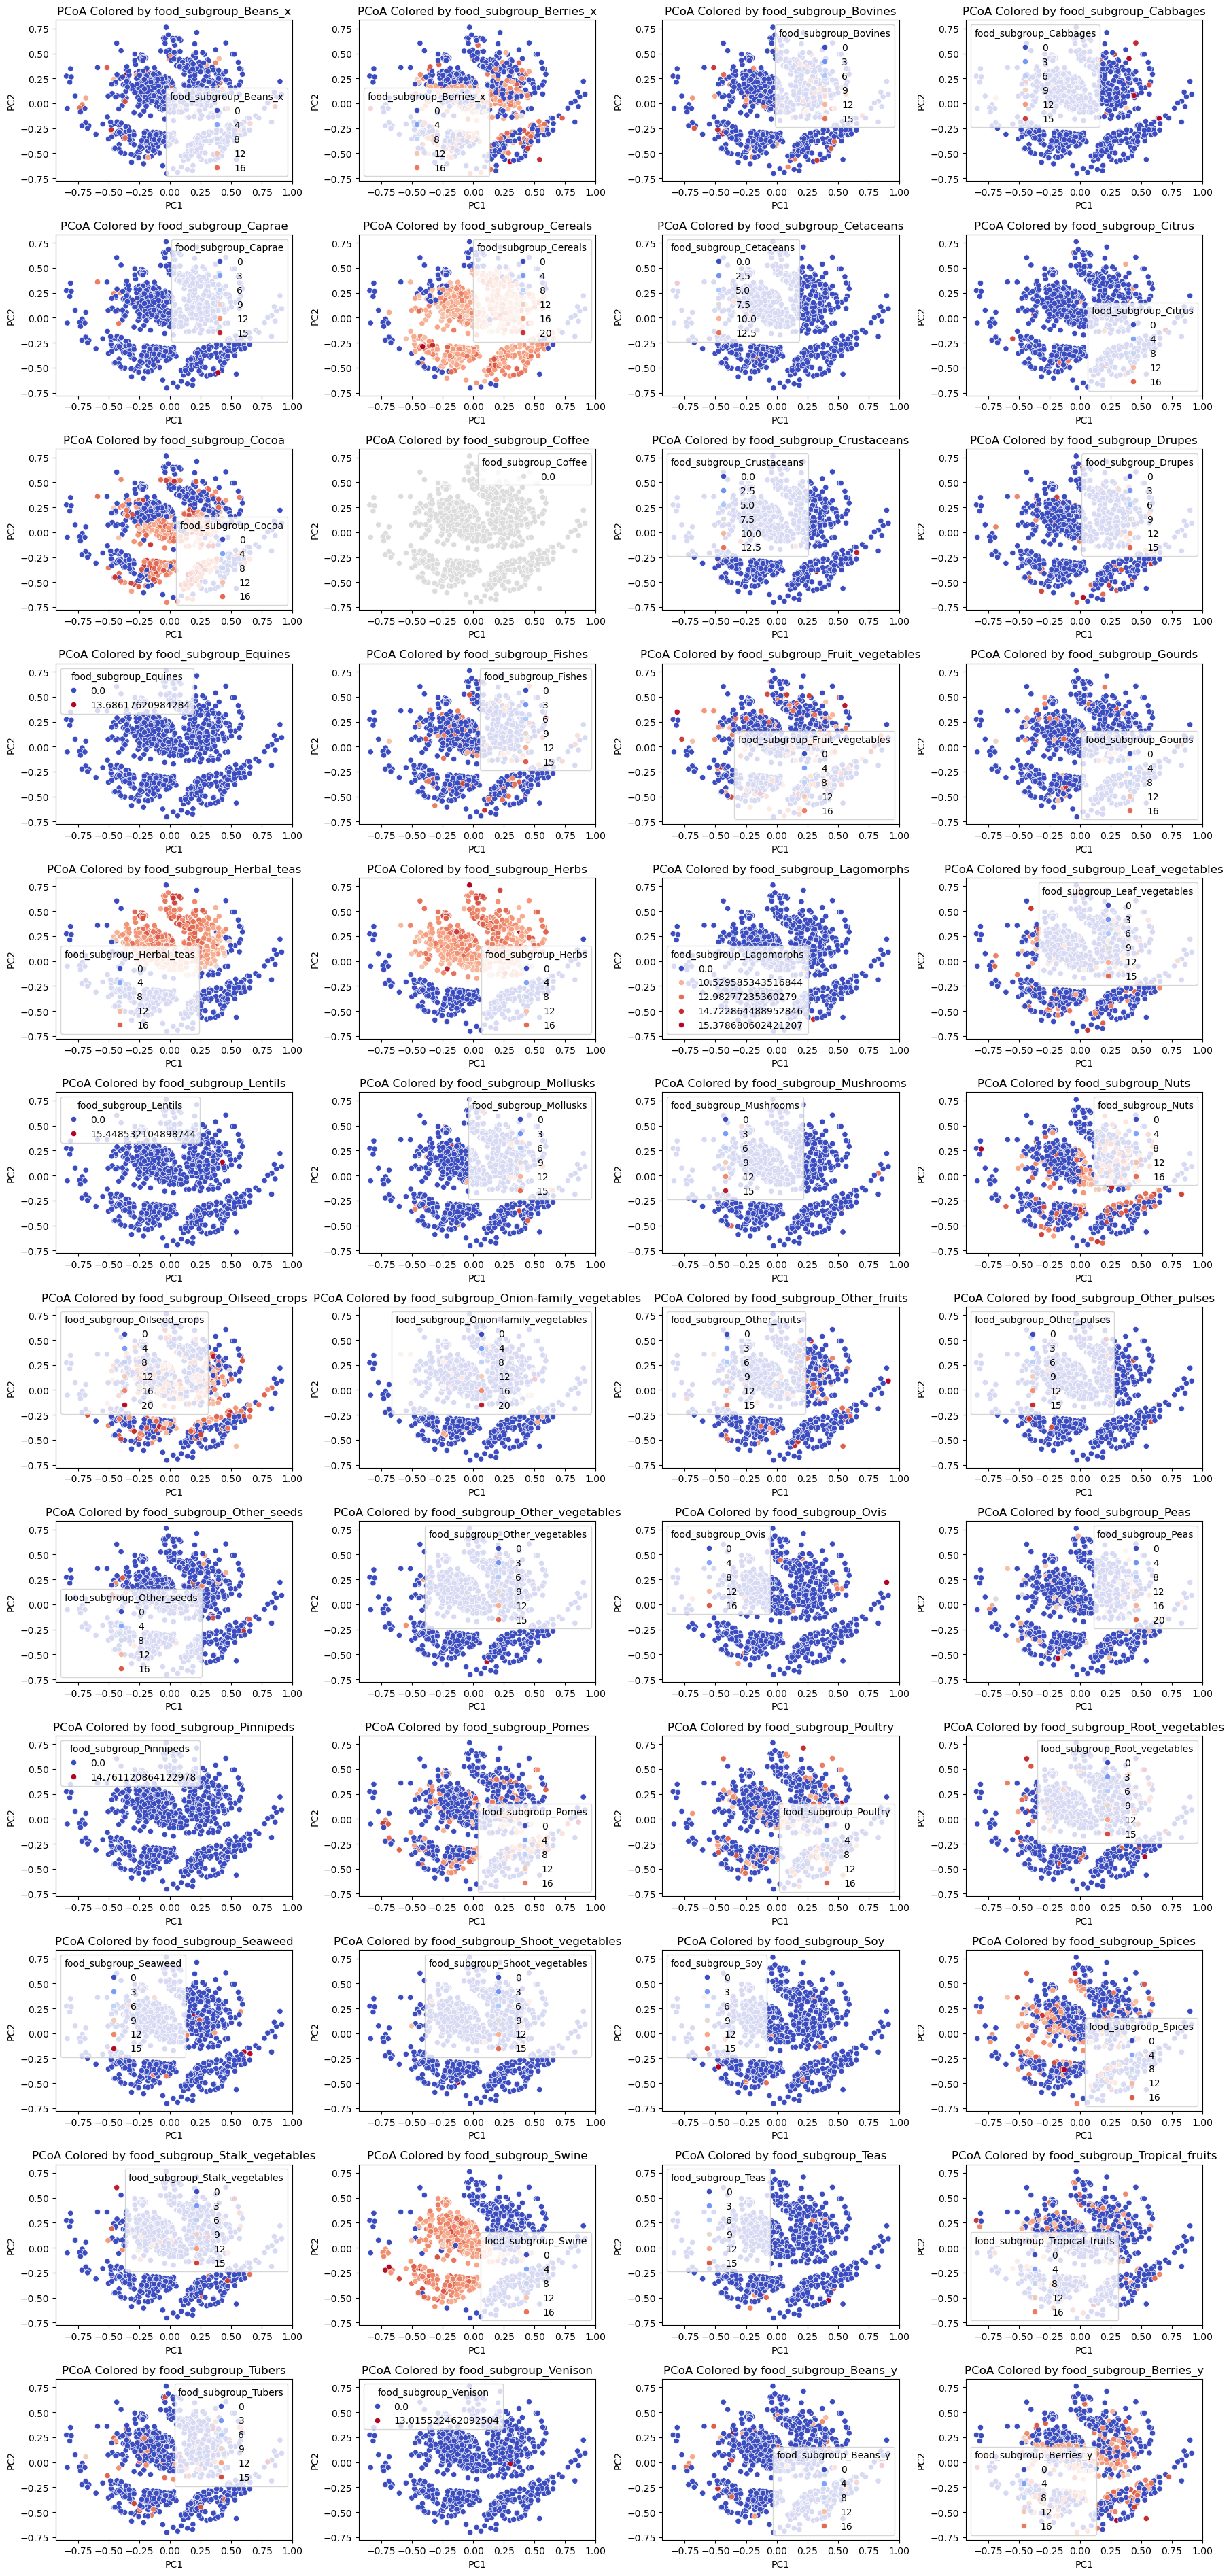

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Identify columns that start with "food_subgroup"
food_subgroup_cols = [col for col in merged_data.columns if col.startswith("food_subgroup")]

# Determine subplot grid size
num_subplots = len(food_subgroup_cols)
cols = 4  # Number of columns in the subplot grid
rows = int(np.ceil(num_subplots / cols))

# Create figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 38))
axes = axes.flatten()

# Loop through each food subgroup and create a subplot
for i, food_col in enumerate(food_subgroup_cols):
    ax = axes[i]

    # Create scatter plot colored by the current food subgroup
    sns.scatterplot(x='PC1', y='PC2', hue=food_col, palette='coolwarm', data=merged_data, ax=ax)

    ax.set_title(f'PCoA Colored by {food_col}')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# Remove any empty subplots if there are more slots than actual plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the plot
plt.tight_layout()
plt.savefig('diet_diversity_pcoa_food_subgroups.pdf', dpi=300)
#plt.show()

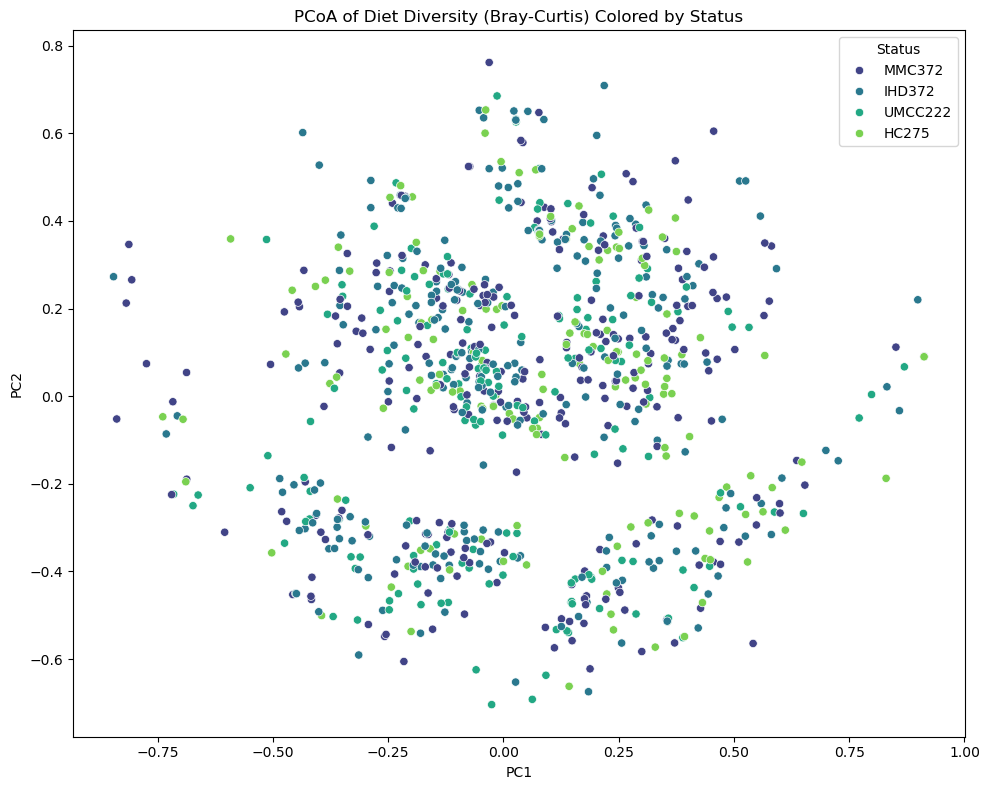


Summary Statistics by Status:

Status: HC275
Number of individuals: 152
Average PC1: 0.0870
Average PC2: 0.0273

Status: IHD372
Number of individuals: 262
Average PC1: 0.0197
Average PC2: 0.0393

Status: MMC372
Number of individuals: 279
Average PC1: 0.0424
Average PC2: 0.0081

Status: UMCC222
Number of individuals: 177
Average PC1: 0.0082
Average PC2: -0.0505

ANOVA test for PC1 by Status:
F-statistic: 2.3071
p-value: 0.0752

Note: For a full PERMANOVA analysis, consider using the 'skbio' package or R's 'vegan' package


In [43]:
# If biomarkers data exists, merge with PCoA results
if biomarkers is not None:
    # Reset index to prepare for merge
    pcoa_df = pcoa_df.reset_index()
    
    # Merge PCoA results with biomarkers data
    merged_data = pd.merge(pcoa_df, biomarkers, on='ID', how='inner')
    
    # Plot PCoA with status coloring
    plt.figure(figsize=(10, 8))
    
    # Check if 'Status' column exists
    if 'Status' in merged_data.columns:
        # Create scatter plot colored by status
        sns.scatterplot(x='PC1', y='PC2', 
                       hue='Status', 
                       palette='viridis',  # You can change the palette if needed
                       data=merged_data)
        
        plt.title('PCoA of Diet Diversity (Bray-Curtis) Colored by Status')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(title='Status')
    else:
        # If 'Status' column doesn't exist, try to find an alternative status column
        status_cols = [col for col in merged_data.columns if 'status' in col.lower()]
        if status_cols:
            print(f"'Status' column not found. Using {status_cols[0]} instead.")
            sns.scatterplot(x='PC1', y='PC2', 
                           hue=status_cols[0], 
                           palette='viridis',
                           data=merged_data)
            plt.title(f'PCoA of Diet Diversity (Bray-Curtis) Colored by {status_cols[0]}')
        else:
            # Default plot without coloring
            sns.scatterplot(x='PC1', y='PC2', data=merged_data)
            plt.title('PCoA of Diet Diversity (Bray-Curtis)')
    
    plt.tight_layout()
    plt.savefig('diet_diversity_pcoa.png', dpi=300)
    plt.show()
    
    # Print some statistics about the clustering
    if 'Status' in merged_data.columns:
        status_groups = merged_data.groupby('Status')
        print("\nSummary Statistics by Status:")
        for name, group in status_groups:
            print(f"\nStatus: {name}")
            print(f"Number of individuals: {len(group)}")
            print(f"Average PC1: {group['PC1'].mean():.4f}")
            print(f"Average PC2: {group['PC2'].mean():.4f}")
            
        # Calculate PERMANOVA or ANOSIM if scipy.stats is available
        try:
            from scipy.stats import f_oneway
            
            # Simple ANOVA to test if the groups are significantly different
            f_stat, p_val = f_oneway(
                *[group['PC1'] for name, group in status_groups]
            )
            print(f"\nANOVA test for PC1 by Status:")
            print(f"F-statistic: {f_stat:.4f}")
            print(f"p-value: {p_val:.4f}")
            
            # For a proper PERMANOVA, you would need additional libraries like skbio or vegan in R
            print("\nNote: For a full PERMANOVA analysis, consider using the 'skbio' package or R's 'vegan' package")
        except Exception as e:
            print(f"Error performing statistical tests: {e}")
else:
    # Plot just the PCoA without status
    plt.figure(figsize=(10, 8))
    pcoa_df = pcoa_df.reset_index()
    sns.scatterplot(x='PC1', y='PC2', data=pcoa_df)
    plt.title('PCoA of Diet Diversity (Bray-Curtis)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.savefig('diet_diversity_pcoa_no_status.png', dpi=300)
    plt.show()



In [25]:
# Load the dataset
df1 = pd.read_csv('food_abundance.csv')  
df2 = pd.read_csv('food_abundance_PRJEB38742.csv')
# concatenate the two dataframes
df = pd.concat([df1, df2], axis=0)
# change sample_id to ID
df = df.rename(columns={'sample_id': 'ID'})
# strip the M0 from the ID
df['ID'] = df['ID'].str.strip('M0')
# save to new csv called food_abundance_combined.csv
df.to_csv('food_abundance_combined.csv', index=False)



In [121]:
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import mantel

# Filter diet_data to include only IDs present in biomarkers_cov
filtered_diet_data = diet_data[diet_data.index.isin(biomarkers['ID'])]

# Recalculate Bray-Curtis dissimilarity matrix for the filtered diet data
numeric_filtered_diet_data = filtered_diet_data.apply(pd.to_numeric, errors='coerce').fillna(0)
bray_curtis_matrix_filtered = pairwise_distances(numeric_filtered_diet_data, metric='braycurtis')

# Create a DataFrame for the updated Bray-Curtis matrix
bc_df_filtered = pd.DataFrame(bray_curtis_matrix_filtered, 
                              index=filtered_diet_data.index, 
                              columns=filtered_diet_data.index)

# Extract HMG and HBA1C values for the same IDs
biomarkers_filtered = biomarkers.set_index('ID').loc[filtered_diet_data.index]
biomarkers_filtered = biomarkers_filtered[['HMG', 'hba1c','Statin']].dropna()  # Drop NaNs to avoid errors

# Ensure diet data is also filtered accordingly
filtered_ids = biomarkers_filtered.index
bc_df_filtered = bc_df_filtered.loc[filtered_ids, filtered_ids]

# Compute Euclidean distance matrices for HMG and HBA1C
dist_hmg = squareform(pdist(biomarkers_filtered[['HMG']], metric='euclidean'))
dist_hba1c = squareform(pdist(biomarkers_filtered[['hba1c']], metric='euclidean'))

# Perform Mantel test between Bray-Curtis and HMG distances
mantel_hmg_stat, mantel_hmg_pval, _ = mantel(bc_df_filtered.values, dist_hmg, method='pearson', permutations=999)
print(f"Mantel test between Bray-Curtis and HMG: r={mantel_hmg_stat:.4f}, p-value={mantel_hmg_pval:.4f}")

# Perform Mantel test between Bray-Curtis and HBA1C distances
mantel_hba1c_stat, mantel_hba1c_pval, _ = mantel(bc_df_filtered.values, dist_hba1c, method='pearson', permutations=999)
print(f"Mantel test between Bray-Curtis and HBA1C: r={mantel_hba1c_stat:.4f}, p-value={mantel_hba1c_pval:.4f}")

Mantel test between Bray-Curtis and HMG: r=0.0274, p-value=0.1230
Mantel test between Bray-Curtis and HBA1C: r=0.0604, p-value=0.0020


In [128]:
from skbio.stats.distance import permanova, DistanceMatrix

# Perform PERMANOVA test
bc_distance_matrix = DistanceMatrix(bc_df_filtered.values, list(filtered_ids))
biomarkers_filtered['HMG_Group'] = pd.qcut(biomarkers_filtered['HMG'], q=4, labels=["Low", "midlo","midhi", "High"])
biomarkers_filtered['HBA1C_Group'] = pd.qcut(biomarkers_filtered['hba1c'], q=4, labels=["Low", "midlo","midhi", "High"])

permanova_hmg = permanova(bc_distance_matrix, biomarkers_filtered['HMG_Group'], permutations=999)
print("\nPERMANOVA test for Bray-Curtis dissimilarity and HMG groups:")
print(permanova_hmg)

permanova_hba1c = permanova(bc_distance_matrix, biomarkers_filtered['HBA1C_Group'], permutations=999)
print("\nPERMANOVA test for Bray-Curtis dissimilarity and HBA1C groups:")
print(permanova_hba1c)



PERMANOVA test for Bray-Curtis dissimilarity and HMG groups:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     854
number of groups                  4
test statistic             1.181055
p-value                        0.26
number of permutations          999
Name: PERMANOVA results, dtype: object

PERMANOVA test for Bray-Curtis dissimilarity and HBA1C groups:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     854
number of groups                  4
test statistic             2.484214
p-value                       0.002
number of permutations          999
Name: PERMANOVA results, dtype: object


In [133]:
# Repeat the same process but only for individuals with Statin = 1
biomarkers_statin_1 = biomarkers_filtered[biomarkers_filtered['Statin'] == 1]
filtered_ids_statin_1 = biomarkers_statin_1.index
bc_df_statin_1 = bc_df_filtered.loc[filtered_ids_statin_1, filtered_ids_statin_1]

# Compute Euclidean distance matrices for HMG and HBA1C (Statin = 1)
dist_hmg_statin_1 = squareform(pdist(biomarkers_statin_1[['HMG']], metric='euclidean'))
dist_hba1c_statin_1 = squareform(pdist(biomarkers_statin_1[['hba1c']], metric='euclidean'))

# Perform Mantel test (Statin = 1)
mantel_hmg_stat_statin_1, mantel_hmg_pval_statin_1, _ = mantel(bc_df_statin_1.values, dist_hmg_statin_1, method='pearson', permutations=999)
print(f"Mantel test (Statin=1) between Bray-Curtis and HMG: r={mantel_hmg_stat_statin_1:.4f}, p-value={mantel_hmg_pval_statin_1:.4f}")

mantel_hba1c_stat_statin_1, mantel_hba1c_pval_statin_1, _ = mantel(bc_df_statin_1.values, dist_hba1c_statin_1, method='pearson', permutations=999)
print(f"Mantel test (Statin=1) between Bray-Curtis and HBA1C: r={mantel_hba1c_stat_statin_1:.4f}, p-value={mantel_hba1c_pval_statin_1:.4f}")

# Perform PERMANOVA test (Statin = 1)
bc_distance_matrix_statin_1 = DistanceMatrix(bc_df_statin_1.values, list(filtered_ids_statin_1))
biomarkers_statin_1['HMG_Group'] = pd.qcut(biomarkers_statin_1['HMG'], q=2)
biomarkers_statin_1['HBA1C_Group'] = pd.qcut(biomarkers_statin_1['hba1c'], q=2)

permanova_hmg_statin_1 = permanova(bc_distance_matrix_statin_1, biomarkers_statin_1['HMG_Group'], permutations=999)
print("\nPERMANOVA test (Statin=1) for Bray-Curtis dissimilarity and HMG groups:")
print(permanova_hmg_statin_1)

permanova_hba1c_statin_1 = permanova(bc_distance_matrix_statin_1, biomarkers_statin_1['HBA1C_Group'], permutations=999)
print("\nPERMANOVA test (Statin=1) for Bray-Curtis dissimilarity and HBA1C groups:")
print(permanova_hba1c_statin_1)

Mantel test (Statin=1) between Bray-Curtis and HMG: r=0.0047, p-value=0.8800
Mantel test (Statin=1) between Bray-Curtis and HBA1C: r=0.0109, p-value=0.7330


/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_6829/2840122067.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biomarkers_statin_1['HMG_Group'] = pd.qcut(biomarkers_statin_1['HMG'], q=2)
/var/folders/0p/3l67fvd177l7t51yqw473srr0000gn/T/ipykernel_6829/2840122067.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biomarkers_statin_1['HBA1C_Group'] = pd.qcut(biomarkers_statin_1['hba1c'], q=2)



PERMANOVA test (Statin=1) for Bray-Curtis dissimilarity and HMG groups:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     328
number of groups                  2
test statistic             0.715028
p-value                       0.689
number of permutations          999
Name: PERMANOVA results, dtype: object

PERMANOVA test (Statin=1) for Bray-Curtis dissimilarity and HBA1C groups:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     328
number of groups                  2
test statistic             1.190512
p-value                       0.302
number of permutations          999
Name: PERMANOVA results, dtype: object


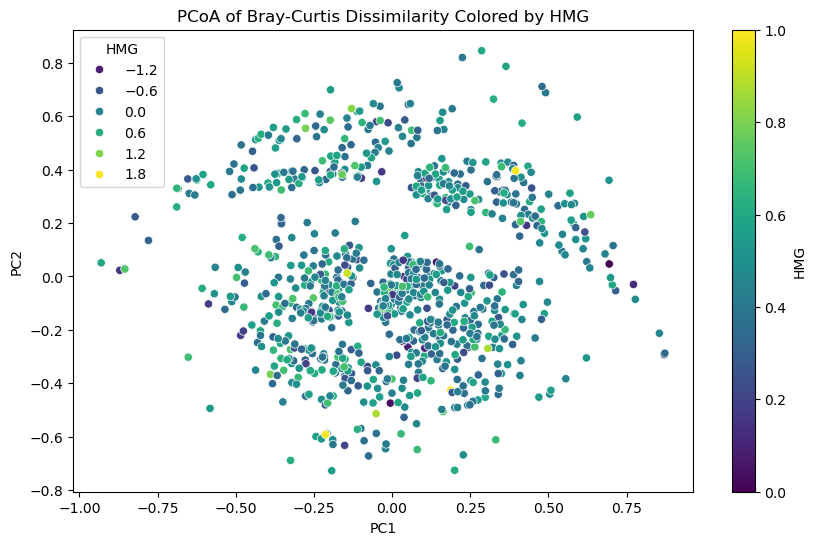

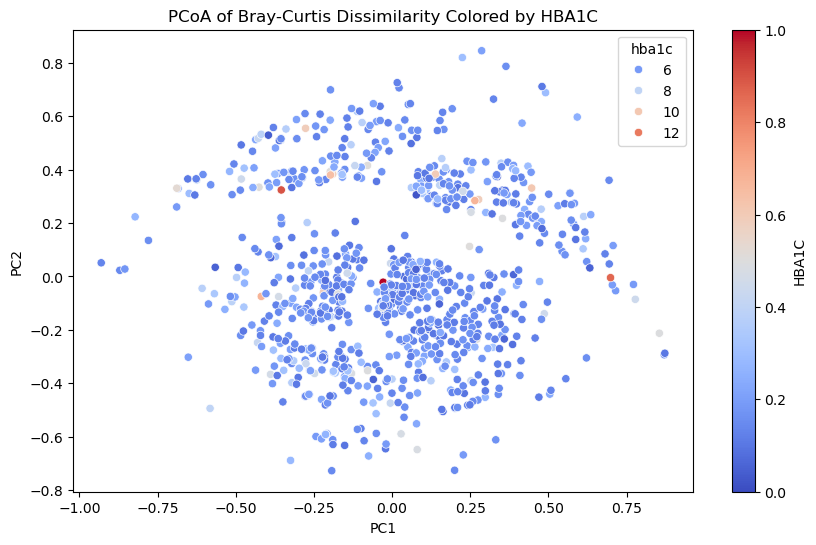

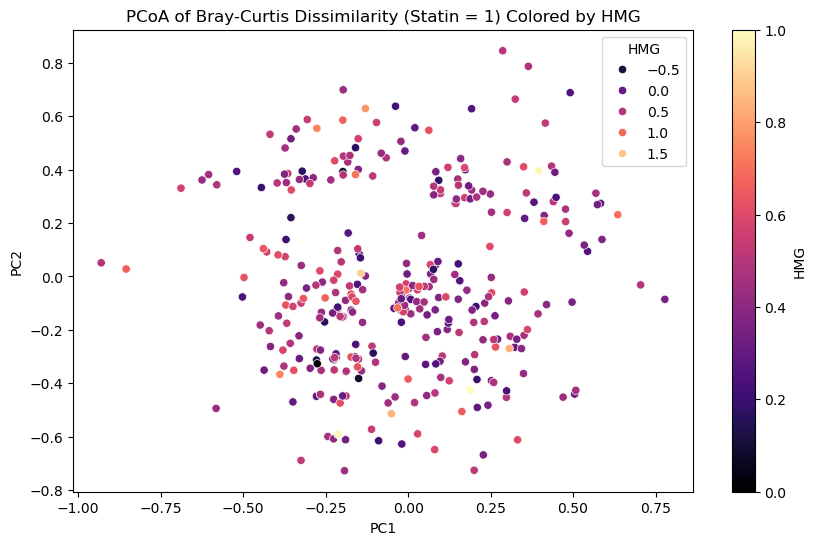

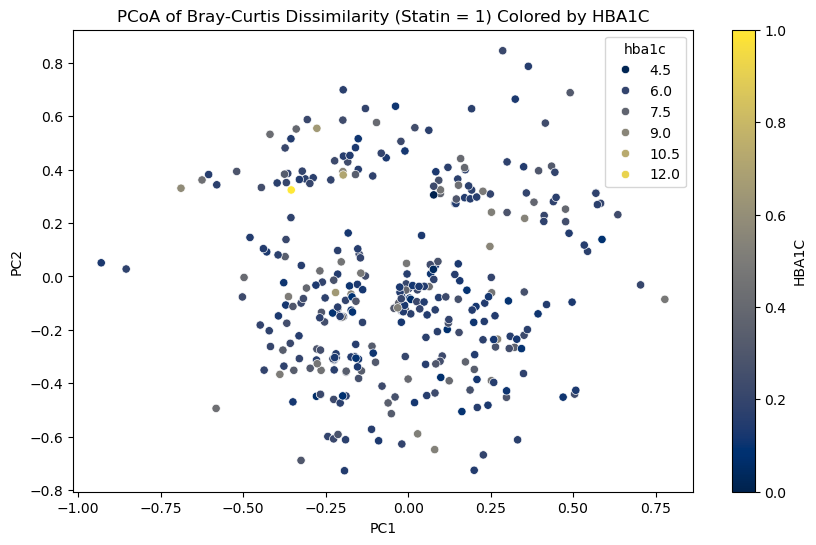

In [126]:
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import mantel, permanova, DistanceMatrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
import numpy as np

# Filter diet_data to include only IDs present in biomarkers_cov
# this brings it from ~1800 to ~800 
filtered_diet_data = diet_data[diet_data.index.isin(biomarkers['ID'])]

# Recalculate Bray-Curtis dissimilarity matrix for the filtered diet data
numeric_filtered_diet_data = filtered_diet_data.apply(pd.to_numeric, errors='coerce').fillna(0)
bray_curtis_matrix_filtered = pairwise_distances(numeric_filtered_diet_data, metric='braycurtis')

# Create a DataFrame for the updated Bray-Curtis matrix
bc_df_filtered = pd.DataFrame(bray_curtis_matrix_filtered, 
                              index=filtered_diet_data.index, 
                              columns=filtered_diet_data.index)

# Extract HMG and HBA1C values for the same IDs
biomarkers_filtered = biomarkers.set_index('ID').loc[filtered_diet_data.index]
biomarkers_filtered = biomarkers_filtered[['HMG', 'hba1c', 'Statin']].dropna()  # Drop NaNs to avoid errors

# Ensure diet data is also filtered accordingly
filtered_ids = biomarkers_filtered.index
bc_df_filtered = bc_df_filtered.loc[filtered_ids, filtered_ids]

# Perform PCoA (using MDS with a precomputed distance matrix)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_results = mds.fit_transform(bc_df_filtered.values)
pcoa_df = pd.DataFrame(pcoa_results, columns=['PC1', 'PC2'], index=filtered_ids)

# Merge PCoA results with biomarkers
pcoa_df = pcoa_df.merge(biomarkers_filtered, left_index=True, right_index=True)

# Visualize PCoA colored by HMG
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=pcoa_df['HMG'], palette='viridis', data=pcoa_df)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gca())
cbar.set_label('HMG')
plt.title("PCoA of Bray-Curtis Dissimilarity Colored by HMG")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Visualize PCoA colored by HBA1C
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=pcoa_df['hba1c'], palette='coolwarm', data=pcoa_df)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='coolwarm'), ax=plt.gca())
cbar.set_label('HBA1C')
plt.title("PCoA of Bray-Curtis Dissimilarity Colored by HBA1C")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Repeat visualization only for individuals with Statin = 1
pcoa_df_statin_1 = pcoa_df[pcoa_df['Statin'] == 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=pcoa_df_statin_1['HMG'], palette='magma', data=pcoa_df_statin_1)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax=plt.gca())
cbar.set_label('HMG')
plt.title("PCoA of Bray-Curtis Dissimilarity (Statin = 1) Colored by HMG")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue=pcoa_df_statin_1['hba1c'], palette='cividis', data=pcoa_df_statin_1)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='cividis'), ax=plt.gca())
cbar.set_label('HBA1C')
plt.title("PCoA of Bray-Curtis Dissimilarity (Statin = 1) Colored by HBA1C")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()